In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Input, GRU, Dense,Flatten,Dropout,Conv1D, MaxPooling1D
from keras.callbacks import EarlyStopping
from keras.losses import mean_squared_error
import mlflow.tensorflow
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
def create_sequences(dataset, timesteps=1, dropNa=True):
    """Converts time series into a data set for supervised machine learning models"""
    # drop row's which include Nan elements (data preprocessing)
    df = pd.DataFrame(dataset)
    if dropNa:
        df.dropna(inplace=True)
    dataset = df.values
    # create x and y out of dataset
    dataX, dataY = [], []
    for i in range(len(dataset)):
        endIdx = i + timesteps
        # stop if reached the end of dataset
        if endIdx + 1 > len(dataset):
            break
        dataX.append(dataset[i:endIdx, :])
        dataY.append(dataset[endIdx, :])
    return np.array(dataX), np.array(dataY)

In [3]:
def test_train(datasetsize, testsize, shuffle=True):
    """Returns two dataset to train and test machine learning models"""
    if shuffle:
        ntest = int(np.ceil(testsize * datasetsize))
        idx = np.arange(0, datasetsize)
        np.random.shuffle(idx)
        train_index = idx[ntest:]
        test_index = idx[:ntest]
        return train_index, test_index
    else:
        #TODO: Check datasplitting use int(np.ceil(testsize * datasetsize))
        ntest = int(np.ceil(testsize * datasetsize))
        idx = np.arange(0, datasetsize)
        test_index = idx[datasetsize - ntest:]
        train_index = idx[:datasetsize - ntest]
        return train_index, test_index

In [4]:
def LSTM_model():
    model = ks.Sequential()
    model.add(ks.layers.LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(ks.layers.LSTM(units=50, return_sequences=False))
    model.add(ks.layers.Dense(units=25))
    model.add(ks.layers.Dense(units=1))
    model.compile(optimizer='adam',
              loss=mean_squared_error,
              metrics=['accuracy'])
    return model

In [5]:
def CNN_model():
    model = Sequential()
    model.add(Conv1D(filters=50, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
    #model.add(ks.layers.Conv1D(filters=50, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(Flatten())
    model.add(Dense(units=2))
    model.compile(optimizer='adam',
              loss=mean_squared_error,
              metrics=['accuracy'])
    return model

In [6]:
# Create a test Sequence
seq = [[1,101],[2,102],[3,103],[4,104],[5,105],[6,106],[7,107],[8,108],[9,109],[10,110]]
timesteps = 5
dropNan = False
shuffle = False

In [7]:
X_Data, y_Data = create_sequences(seq, timesteps, dropNan)

In [8]:
train_index, test_index = test_train(len(X_Data), 0.33, shuffle)
print(train_index,test_index)

[0 1 2] [3 4]


In [9]:
# rename the columns of y_Data
X_train = X_Data[train_index]
X_test = X_Data[test_index]
y_train = y_Data[train_index]
y_test = y_Data[test_index]

In [10]:
n_features = X_train.shape[2]
n_period = X_train.shape[1]
n_samples = X_train.shape[0]
print(n_features,n_period,n_samples)

2 5 3


In [11]:
model = Sequential()
model.add(Conv1D(filters=50, kernel_size=3, activation='relu', input_shape=(n_period, n_features)))
#model.add(Conv1D(filters=50, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dropout(0.20))
model.add(Dense(units=2))
model.compile(optimizer='adam',
          loss=mean_squared_error,
          metrics=['accuracy'])
model.summary()

history = model.fit(
    X_train,
    y_train,
    batch_size=1,
    epochs=100,
    validation_data=(X_test, y_test),
    callbacks=[
        EarlyStopping(patience=10),
    ],
)

C:\Users\steph\anaconda3\envs\ami-cpu\lib\site-packages\keras\engine\training_utils.py:811: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if isinstance(loss, collections.Mapping):


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 3, 50)             350       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1, 50)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 50)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 102       
Total params: 452
Trainable params: 452
Non-trainable params: 0
_________________________________________________________________
Train on 3 samples, validate on 2 samples
Epoch 1/100
3/3 [==============================] - 0s 143ms/step - loss: 3420.73

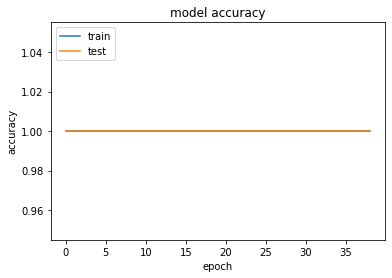

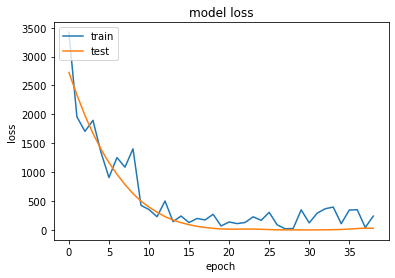

In [12]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [13]:
print(y_train[0])
model.predict(np.reshape(X_train[0], (1,X_train[0].shape[0], X_train[0].shape[1])))

[  6 106]


array([[  1.6018817, 105.62158  ]], dtype=float32)

In [14]:
predictions = model.predict(X_test)
print(predictions)

[[  1.8872917 109.94421  ]
 [  1.9824321 111.38508  ]]


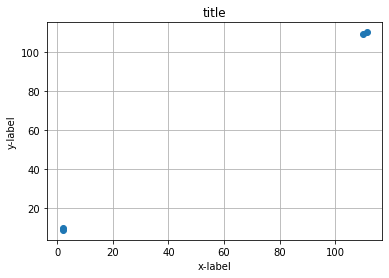

In [15]:
# Visualize the data
plt.figure()
plt.scatter(predictions,y_test)
plt.grid(True)
plt.title("title")
plt.xlabel("x-label")
plt.ylabel("y-label")
plt.show()